In this notebook, we show step-by-step how to perform text classification by fine-tuning a BERT-based model.

Here we install the [transformers]( https://github.com/huggingface/transformers) package, from [Hugging Face]( https://huggingface.co/).
We use one of its pre-trained BERT models, more specifically a compact model that is trained through model distillation. We will use the package to:
- Tokenize the text according to the BERT model specification, using its [DistilBertTokenizer]( https://huggingface.co/transformers/model_doc/distilbert.html) class
- Instantiate a pre-trained BERT model, modified for the text classification task, using its [DistilBertForSequenceClassification](https://huggingface.co/transformers/model_doc/distilbert.html) class, that we will then fine-tuning for our specific dataset.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 23.3 MB/s 
     |████████████████████████████████| 596 kB 59.6 MB/s 
     |████████████████████████████████| 6.5 MB 55.3 MB/s 
     |████████████████████████████████| 67 kB 5.3 MB/s 
     |████████████████████████████████| 895 kB 47.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


We then load and inspect the dataset we had previously prepared. In order to train faster, we use the sampled version, which contains 10% of the original prepared dataset.

In [ ]:
import pandas as pd

df = pd.read_csv('./drive/MyDrive/BERT-Google-Colab/youtube_data_prepared.csv')

In [ ]:
df.shape

(3595, 3)

In [ ]:
df.head(10)

,category,description,Category_Label
0,travel,tanya khanijow\n671k subscribers\nsubscribe\nt...,3
1,travel,priscilla lee\n45 6k subscribers\nsubscribe\n ...,3
2,travel,allison anderson\n588k subscribers\nsubscribe\...,3
3,travel,yes theory\n6 65m subscribers\nsubscribe\n bla...,3
4,travel,tanya khanijow\n671k subscribers\nsubscribe\nh...,3
5,travel,mountain trekker\n1 42m subscribers\njoin\nsub...,3
6,travel,treme moto adventure\n800k subscribers\njoin\n...,3
7,travel,visa2explore\n1 21m subscribers\njoin\nsubscri...,3
8,travel,garima s good life\n1 76m subscribers\nsubscri...,3
9,travel,tanya khanijow\n671k subscribers\nsubscribe\nk...,3


In [ ]:
label_counts = pd.DataFrame(df['category'].value_counts())
label_counts

,category
travel,1154
art_music,947
food,901
history,593


Here we create an array with the label names in the order they were numerically encoded. We use them later when plotting model performance data.

In [ ]:
label_values = list(label_counts.index)
order = list(pd.DataFrame(df['Category_Label'].value_counts()).index)
label_values = [l for _,l in sorted(zip(order, label_values))]

label_values

['art_music', 'food', 'history', 'travel']

We need to create 2 arrays: one with the textual data, which is our feature data, and one with the numerically encoded labels, representing our target data.

In [ ]:
texts = df['description'].values
labels = df['Category_Label'].values

BERT is a ‘heavy-weight’´model. This makes the training a very resource-intensive process, specially when we are fine-tuning for all model layers. To mitigate this, we can control the sequence length of our input text, which is given by the number of tokens in our input text, plus 2 special tokens to mark the beginning and ending of a text sequence.


In [ ]:
text_lengths = [len(texts[i].split()) for i in range(len(texts))]
print(min(text_lengths))
print(max(text_lengths))

5
939


In [ ]:
sum([1 for i in range(len(text_lengths)) if text_lengths[i] >= 300])

87

Here we instantiate a BERT tokenizer and show an example of a tokenized text. 

In [ ]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

print('Original Text: ', texts[0], '\n')
print('Tokenized Text: ', tokenizer.tokenize(texts[0]), '\n')
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(texts[0])))

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Original Text:  tanya khanijow
671k subscribers
subscribe
the journey to arunachal north east india begins with a train journey from guwahati to murkongselek from here we head to pasighat and i and my travel companions are just getting started by exploring the tiny glimpse of arunachal that we have so far from markets to bridges the adventure will only get better from here 

next video 
show more 

Tokenized Text:  ['tanya', 'khan', '##ij', '##ow', '67', '##1', '##k', 'subscribers', 'sub', '##scribe', 'the', 'journey', 'to', 'arun', '##achal', 'north', 'east', 'india', 'begins', 'with', 'a', 'train', 'journey', 'from', 'gu', '##wa', '##hat', '##i', 'to', 'mu', '##rk', '##ong', '##sel', '##ek', 'from', 'here', 'we', 'head', 'to', 'pas', '##igh', '##at', 'and', 'i', 'and', 'my', 'travel', 'companions', 'are', 'just', 'getting', 'started', 'by', 'exploring', 'the', 'tiny', 'glimpse', 'of', 'arun', '##achal', 'that', 'we', 'have', 'so', 'far', 'from', 'markets', 'to', 'bridges', 'the', 'ad

We then tokenize and encode the entire dataset. In this process, we perform the following:
- tokenize the text as shown above
- encode it to the corresponding numeric values for each token.
- truncate it to the maximum sequence length of 300.
- pad the tokens positions greater than 300.
- include the special token IDs to mark the beginning and end of each sequence.

In [ ]:
text_ids = [tokenizer.encode(text, max_length=300, pad_to_max_length=True) for text in texts]

text_ids[0]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[101,
 19956,
 4967,
 28418,
 5004,
 6163,
 2487,
 2243,
 17073,
 4942,
 29234,
 1996,
 4990,
 2000,
 28217,
 24409,
 2167,
 2264,
 2634,
 4269,
 2007,
 1037,
 3345,
 4990,
 2013,
 19739,
 4213,
 12707,
 2072,
 2000,
 14163,
 8024,
 5063,
 11246,
 5937,
 2013,
 2182,
 2057,
 2132,
 2000,
 14674,
 18377,
 4017,
 1998,
 1045,
 1998,
 2026,
 3604,
 11946,
 2024,
 2074,
 2893,
 2318,
 2011,
 11131,
 1996,
 4714,
 12185,
 1997,
 28217,
 24409,
 2008,
 2057,
 2031,
 2061,
 2521,
 2013,
 6089,
 2000,
 7346,
 1996,
 6172,
 2097,
 2069,
 2131,
 2488,
 2013,
 2182,
 2279,
 2678,
 2265,
 2062,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [ ]:
text_ids_lengths = [len(text_ids[i]) for i in range(len(text_ids))]
print(min(text_ids_lengths))
print(max(text_ids_lengths))

300
300


To fine-tune our model, we need two inputs: one array of token IDs (created above) and one array of a corresponding binary mask, called attention mask in the BERT model specification. Each attention mask has the same length of the corresponding input sequence and has a 0 if the corresponding token is a pad token, or a 1 otherwise. 

In [ ]:
att_masks = []
for ids in text_ids:
    masks = [int(id > 0) for id in ids]
    att_masks.append(masks)
    
att_masks[0]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


Here we split the input and output arrays created before into train, validation, and test sets. We use 80% of the data for training, 10% for training validation, and 10% for final testing.

In [ ]:
from sklearn.model_selection import train_test_split

train_x, test_val_x, train_y, test_val_y = train_test_split(text_ids, labels, random_state=111, test_size=0.2)
train_m, test_val_m = train_test_split(att_masks, random_state=111, test_size=0.2)

test_x, val_x, test_y, val_y = train_test_split(test_val_x, test_val_y, random_state=111, test_size=0.5)
test_m, val_m = train_test_split(test_val_m, random_state=111, test_size=0.5)

We are working with the PyTorch artifacts in the transformers library, therefore we need our model input and output data as PyTorch tensors.

In [ ]:
import torch

train_x = torch.tensor(train_x)
test_x = torch.tensor(test_x)
val_x = torch.tensor(val_x)
train_y = torch.tensor(train_y)
test_y = torch.tensor(test_y)
val_y = torch.tensor(val_y)
train_m = torch.tensor(train_m)
test_m = torch.tensor(test_m)
val_m = torch.tensor(val_m)

print(train_x.shape)
print(test_x.shape)
print(val_x.shape)
print(train_y.shape)
print(test_y.shape)
print(val_y.shape)
print(train_m.shape)
print(test_m.shape)
print(val_m.shape)

torch.Size([2876, 300])
torch.Size([359, 300])
torch.Size([360, 300])
torch.Size([2876])
torch.Size([359])
torch.Size([360])
torch.Size([2876, 300])
torch.Size([359, 300])
torch.Size([360, 300])


To feed data into the model for training, we use Pytorch’s Dataset, DataLoader, and Sampler. For feeding training data, which drives model weights updates, we use the RandomSampler. For feeding the validation data we can use the SequentialSampler.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_x, train_m, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_x, val_m, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

Here we instantiate our model class. We use a compact version, that is trained through model distillation from a base BERT model and modified to include a classification layer at the output. This compact version has 6 transformer layers instead of 12 as in the original BERT model. Please see [here]( https://github.com/huggingface/transformers/tree/master/examples/distillation) for more details.

In [ ]:
from transformers import DistilBertForSequenceClassification, AdamW, DistilBertConfig

num_labels = len(set(labels))

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels,
                                                            output_attentions=False, output_hidden_states=False)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

BERT is a very large model. Unless you are freezing model weights in all layers but the classification layer, it is recommended to train it on a GPU.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = model.to(device)

cpu


Here we print the model architecture and all model learnable parameters.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Number of trainable parameters:', count_parameters(model), '\n', model)

Number of trainable parameters: 66956548 
 DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (drop

In [ ]:
[n for n, p in model.named_parameters()]

['distilbert.embeddings.word_embeddings.weight',
 'distilbert.embeddings.position_embeddings.weight',
 'distilbert.embeddings.LayerNorm.weight',
 'distilbert.embeddings.LayerNorm.bias',
 'distilbert.transformer.layer.0.attention.q_lin.weight',
 'distilbert.transformer.layer.0.attention.q_lin.bias',
 'distilbert.transformer.layer.0.attention.k_lin.weight',
 'distilbert.transformer.layer.0.attention.k_lin.bias',
 'distilbert.transformer.layer.0.attention.v_lin.weight',
 'distilbert.transformer.layer.0.attention.v_lin.bias',
 'distilbert.transformer.layer.0.attention.out_lin.weight',
 'distilbert.transformer.layer.0.attention.out_lin.bias',
 'distilbert.transformer.layer.0.sa_layer_norm.weight',
 'distilbert.transformer.layer.0.sa_layer_norm.bias',
 'distilbert.transformer.layer.0.ffn.lin1.weight',
 'distilbert.transformer.layer.0.ffn.lin1.bias',
 'distilbert.transformer.layer.0.ffn.lin2.weight',
 'distilbert.transformer.layer.0.ffn.lin2.bias',
 'distilbert.transformer.layer.0.output_laye

In the following 5 cells we define our PyTorch optimizer and corresponding parameters, learning rate scheduler, and the training loop for the fine-tuning procedure. We train for 4 epochs.

In [ ]:
learning_rate = 1e-5
adam_epsilon = 1e-8

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.2},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from transformers import get_linear_schedule_with_warmup

num_epochs = 4
total_steps = len(train_dataloader) * num_epochs
print(total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

180


In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import numpy as np
import random

seed_val = 111

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
train_losses = []
val_losses = []
num_mb_train = len(train_dataloader)
num_mb_val = len(val_dataloader)

if num_mb_val == 0:
    num_mb_val = 1

for n in range(num_epochs):
    train_loss = 0
    val_loss = 0
    start_time = time.time()
    
    for k, (mb_x, mb_m, mb_y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        model.train()
        
        mb_x = mb_x.to(device)
        mb_m = mb_m.to(device)
        mb_y = mb_y.to(device)
        
        outputs = model(mb_x, attention_mask=mb_m, labels=mb_y)
        
        loss = outputs[0]
        #loss = model_loss(outputs[1], mb_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.data / num_mb_train
    
    print ("\nTrain loss after itaration %i: %f" % (n+1, train_loss))
    train_losses.append(train_loss.cpu())
    
    with torch.no_grad():
        model.eval()
        
        for k, (mb_x, mb_m, mb_y) in enumerate(val_dataloader):
            mb_x = mb_x.to(device)
            mb_m = mb_m.to(device)
            mb_y = mb_y.to(device)
        
            outputs = model(mb_x, attention_mask=mb_m, labels=mb_y)
            
            loss = outputs[0]
            #loss = model_loss(outputs[1], mb_y)
            
            val_loss += loss.data / num_mb_val
            
        print ("Validation loss after itaration %i: %f" % (n+1, val_loss))
        val_losses.append(val_loss.cpu())
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Time: {epoch_mins}m {epoch_secs}s')


Train loss after itaration 1: 1.101389
Validation loss after itaration 1: 0.770252
Time: 78m 27s

Train loss after itaration 2: 0.601049
Validation loss after itaration 2: 0.557058
Time: 80m 5s


After training, we can save the model and necessary configuration parameters, to recreate it later and use it to score the test data. Here we also save the losses computed from both training and validation data.

In [ ]:
import pickle
import os

out_dir = './model'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(out_dir)
tokenizer.save_pretrained(out_dir)

with open(out_dir + '/train_losses.pkl', 'wb') as f:
    pickle.dump(train_losses, f)
    
with open(out_dir + '/val_losses.pkl', 'wb') as f:
    pickle.dump(val_losses, f)

In [ ]:
out_dir = './model'

model = DistilBertForSequenceClassification.from_pretrained(out_dir)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

with open(out_dir + '/train_losses.pkl', 'rb') as f:
    train_losses = pickle.load(f)
    
with open(out_dir + '/val_losses.pkl', 'rb') as f:
    val_losses = pickle.load(f)

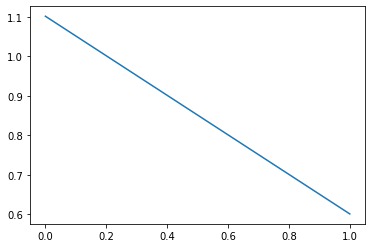

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(train_losses)

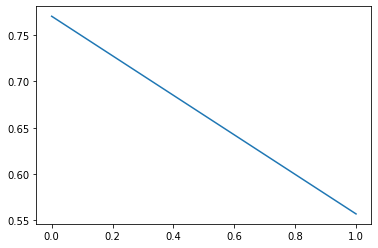

In [ ]:
plt.figure()
plt.plot(val_losses)

After instantiating a trained model, we can then score the test data and compute its accuracy. We then print the classification report and plot a confusion matrix.

The trained model gives us good results on the test data, being able to correctly classify 80% or more on each of the 6 distinct categories.

In [ ]:
batch_size = 32

test_data = TensorDataset(test_x, test_m)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

outputs = []
with torch.no_grad():
    model.eval()
    for k, (mb_x, mb_m) in enumerate(test_dataloader):
        mb_x = mb_x.to(device)
        mb_m = mb_m.to(device)
        output = model(mb_x, attention_mask=mb_m)
        outputs.append(output[0].to('cpu'))

outputs = torch.cat(outputs)

In [ ]:
_, predicted_values = torch.max(outputs, 1)
predicted_values = predicted_values.numpy()
true_values = test_y.numpy()

In [ ]:
test_accuracy = np.sum(predicted_values == true_values) / len(true_values)
print ("Test Accuracy:", test_accuracy)

Test Accuracy: 0.8941504178272981


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true_values, predicted_values, target_names=[str(l) for l in label_values]))

              precision    recall  f1-score   support

   art_music       0.90      0.96      0.93       101
        food       0.94      0.83      0.88        96
     history       0.98      0.81      0.88        57
      travel       0.82      0.93      0.87       105

    accuracy                           0.89       359
   macro avg       0.91      0.88      0.89       359
weighted avg       0.90      0.89      0.89       359



In [ ]:
import itertools

# plot confusion matrix
# code borrowed from scikit-learn.org
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[97  0  1  3]
 [ 5 80  0 11]
 [ 3  1 46  7]
 [ 3  4  0 98]]
Normalized confusion matrix
[[0.96 0.   0.01 0.03]
 [0.05 0.83 0.   0.11]
 [0.05 0.02 0.81 0.12]
 [0.03 0.04 0.   0.93]]


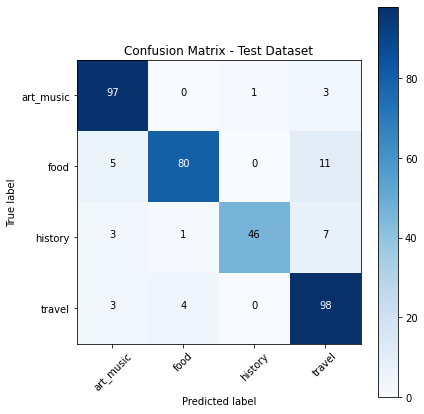

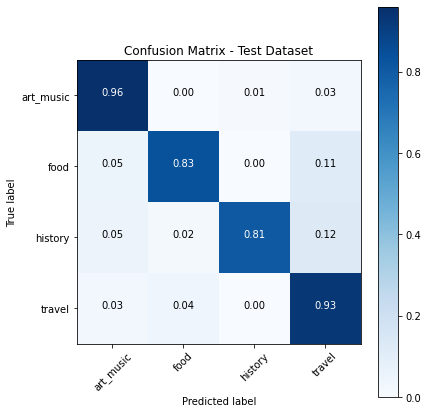

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

cm_test = confusion_matrix(true_values, predicted_values)

np.set_printoptions(precision=2)

plt.figure(figsize=(6,6))
plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset')
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset', normalize=True)